<a href="https://colab.research.google.com/github/dhinnn/Engine-Faults-Detection/blob/main/try1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install yt-dlp pydub librosa matplotlib scikit-learn tensorflow noisereduce opencv-python-headless soundfile joblib


import os, glob, random, yt_dlp, cv2, joblib
import numpy as np, matplotlib.pyplot as plt
import librosa, librosa.display, soundfile as sf
import noisereduce as nr
from pydub import AudioSegment
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Set random seed for reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


In [9]:
# --------------------------
# STEP 1: Define Labels and YouTube Links
# --------------------------

# Dictionary of engine faults with multiple links per class for redundancy
fault_links = {
    "Normal": [
        "https://youtu.be/U5M0gb0nXiw"
    ],
    "Misfire": [
        "https://youtu.be/74ZTtGh5MN8"
    ],
    "Knocking": [
        "https://youtu.be/kBWXxWD7g30",
        "https://www.youtube.com/watch?v=rG7s-gXrd10"
    ],
    "Tapping_Clicking": [
        "https://youtu.be/O__pRR2HCS0"
    ],
    "Rod_Knock": [
        "https://youtu.be/wmtBqNnnvrs"
    ],
    "Exhaust_Leak": [
        "https://youtu.be/B9vCVByesGI"
    ],
    "Timing_Chain": [
        "https://www.youtube.com/watch?v=lgTNkW0sj18",
        "https://youtu.be/2UcWsCP42t0"
    ]
}

# Dataset directories
dataset_dir = os.path.join("/content", "engine_sounds")
spec_dir = os.path.join("/content", "spectrograms")

# Create directories if not already present
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(spec_dir, exist_ok=True)

print("✅ Dataset directories ready!")
print("Classes:", list(fault_links.keys()))


✅ Dataset directories ready!
Classes: ['Normal', 'Misfire', 'Knocking', 'Tapping_Clicking', 'Rod_Knock', 'Exhaust_Leak', 'Timing_Chain']


In [10]:
# --------------------------
# STEP 2: Download Audio from YouTube
# --------------------------
import glob

# Guards: ensure STEP 1 (Cell 2) ran
if 'fault_links' not in globals():
    raise NameError("fault_links is not defined. Please run STEP 1 (the cell that defines labels and links) before this cell.")
if 'dataset_dir' not in globals():
    dataset_dir = os.path.join("/content", "engine_sounds")
    os.makedirs(dataset_dir, exist_ok=True)

def download_audio(url, label):
    """Download audio from YouTube and save as .wav inside label folder"""
    label_dir = os.path.join(dataset_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': f'{label_dir}/%(id)s.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
        'quiet': True
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        print(f"✅ Downloaded: {label} ({url})")
    except Exception as e:
        print(f"⚠️ Failed to download {label} from {url} | Error: {e}")

# Loop through classes and download
for label, urls in fault_links.items():
    for url in urls:
        print(f"⬇️ Downloading {label} from {url}")
        download_audio(url, label)

print("\n✅ All downloads finished!")

# Quick sanity check: Count .wav per class
for L in fault_links:
    wav_files = glob.glob(os.path.join(dataset_dir, L, "*.wav"))
    print(f"{L}: {len(wav_files)} files")


⬇️ Downloading Normal from https://youtu.be/U5M0gb0nXiw
✅ Downloaded: Normal (https://youtu.be/U5M0gb0nXiw)
⬇️ Downloading Misfire from https://youtu.be/74ZTtGh5MN8
✅ Downloaded: Misfire (https://youtu.be/74ZTtGh5MN8)
⬇️ Downloading Knocking from https://youtu.be/kBWXxWD7g30
✅ Downloaded: Knocking (https://youtu.be/kBWXxWD7g30)
⬇️ Downloading Knocking from https://www.youtube.com/watch?v=rG7s-gXrd10
✅ Downloaded: Knocking (https://www.youtube.com/watch?v=rG7s-gXrd10)
⬇️ Downloading Tapping_Clicking from https://youtu.be/O__pRR2HCS0
✅ Downloaded: Tapping_Clicking (https://youtu.be/O__pRR2HCS0)
⬇️ Downloading Rod_Knock from https://youtu.be/wmtBqNnnvrs
✅ Downloaded: Rod_Knock (https://youtu.be/wmtBqNnnvrs)
⬇️ Downloading Exhaust_Leak from https://youtu.be/B9vCVByesGI
✅ Downloaded: Exhaust_Leak (https://youtu.be/B9vCVByesGI)
⬇️ Downloading Timing_Chain from https://www.youtube.com/watch?v=lgTNkW0sj18
✅ Downloaded: Timing_Chain (https://www.youtube.com/watch?v=lgTNkW0sj18)
⬇️ Downloading T

In [17]:
# ==========================
# STEP 3: Noise Reduction + Slice into 5-sec Clips
# ==========================
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=50.0, highcut=5000.0, fs=16000, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def denoise_audio(file_path, out_path):
    y, sr = librosa.load(file_path, sr=16000)
    y = bandpass_filter(y, lowcut=50, highcut=5000, fs=sr)
    reduced = nr.reduce_noise(y=y, sr=sr, stationary=True)
    sf.write(out_path, reduced, sr)  # save cleaned file

def slice_and_denoise(label_dir):
    for file in os.listdir(label_dir):
        if file.endswith(".wav") and not file.endswith("_clean.wav"):
            filepath = os.path.join(label_dir, file)

            # Cleaned output
            clean_path = filepath.replace(".wav", "_clean.wav")
            denoise_audio(filepath, clean_path)

            # Slice into 5-sec clips
            audio = AudioSegment.from_wav(clean_path)
            duration = len(audio) // 1000  # in seconds
            for i in range(0, duration, 5):
                clip_path = f"{label_dir}/{os.path.basename(file)[:-4]}_slice{i}.wav"
                clip = audio[i*1000:(i+5)*1000]
                if len(clip) > 1000:  # only save if clip > 1 sec
                    clip.export(clip_path, format="wav")

# Run cleaning + slicing for all classes
for label in fault_links.keys():
    slice_and_denoise(os.path.join(dataset_dir, label))

print("✅ Audio cleaned + sliced into 5-sec clips!")







✅ Audio cleaned + sliced into 5-sec clips!


🔽 Capped Normal: 112 → 50
🔽 Capped Misfire: 118 → 50
🔽 Capped Knocking: 157 → 50
🔽 Capped Tapping_Clicking: 202 → 50
🔽 Capped Rod_Knock: 116 → 50
🔽 Capped Exhaust_Leak: 149 → 50
🔽 Capped Timing_Chain: 318 → 50


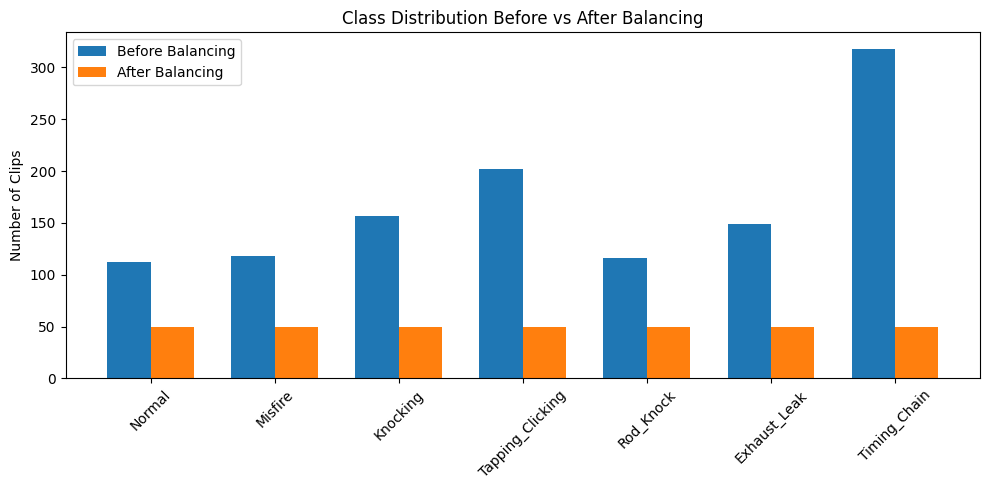

📊 Saved dataset balance plot: class_distribution_balancing.png
Normal: 112 → 50 clips
Misfire: 118 → 50 clips
Knocking: 157 → 50 clips
Tapping_Clicking: 202 → 50 clips
Rod_Knock: 116 → 50 clips
Exhaust_Leak: 149 → 50 clips
Timing_Chain: 318 → 50 clips
✅ All spectrograms saved in 224x224 format after balancing!


In [18]:
# ==========================
# STEP 3.5 + 4: Balance Dataset + Generate Spectrograms
# ==========================
import glob, shutil, random, cv2, pandas as pd

def balance_dataset(dataset_dir, min_clips=20, max_clips=50):
    """
    Balances dataset by oversampling minority classes (duplicate clips)
    and capping max clips for dominant classes.
    """
    stats_before, stats_after = {}, {}

    for label in fault_links.keys():
        label_dir = os.path.join(dataset_dir, label)
        clips = glob.glob(os.path.join(label_dir, "*.wav"))
        stats_before[label] = len(clips)

        if len(clips) == 0:
            print(f"⚠️ Skipping {label}, no clips found.")
            continue

        # Oversample minority
        if len(clips) < min_clips:
            needed = min_clips - len(clips)
            for i in range(needed):
                src = random.choice(clips)
                dst = os.path.join(label_dir, f"aug_{i}_{os.path.basename(src)}")
                shutil.copy(src, dst)
            stats_after[label] = min_clips
            print(f"🔼 Oversampled {label}: {len(clips)} → {min_clips}")

        # Cap dominant
        elif len(clips) > max_clips:
            keep = random.sample(clips, max_clips)
            for c in clips:
                if c not in keep:
                    os.remove(c)
            stats_after[label] = max_clips
            print(f"🔽 Capped {label}: {len(clips)} → {max_clips}")

        else:
            stats_after[label] = len(clips)
            print(f"✅ {label} already balanced: {len(clips)} clips")

    return stats_before, stats_after

# Run balancing
stats_before, stats_after = balance_dataset(dataset_dir, min_clips=20, max_clips=50)

# --------------------------
# Plot class distribution before vs after
# --------------------------
labels = list(fault_links.keys())
before_counts = [stats_before.get(l, 0) for l in labels]
after_counts = [stats_after.get(l, 0) for l in labels]

x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - bar_width/2, before_counts, bar_width, label="Before Balancing")
plt.bar(x + bar_width/2, after_counts, bar_width, label="After Balancing")
plt.xticks(x, labels, rotation=45)
plt.ylabel("Number of Clips")
plt.title("Class Distribution Before vs After Balancing")
plt.legend()
plt.tight_layout()
plt.savefig("class_distribution_balancing.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Saved dataset balance plot: class_distribution_balancing.png")

# Quick check printout
for L in fault_links:
    print(f"{L}: {stats_before.get(L, 0)} → {stats_after.get(L, 0)} clips")

# --------------------------
# STEP 4: Generate Spectrograms after balancing
# --------------------------
def save_spectrogram(file_path, label, count):
    y, sr = librosa.load(file_path, sr=16000)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(2.24, 2.24), dpi=100)  # ensures ~224x224
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.axis("off")

    label_dir = os.path.join(spec_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    save_path = os.path.join(label_dir, f"{label}_{count}.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Resize to exactly 224x224
    img = cv2.imread(save_path)
    img_resized = cv2.resize(img, (224, 224))
    cv2.imwrite(save_path, img_resized)

# Generate spectrograms
count = 0
for label in fault_links.keys():
    label_path = os.path.join(dataset_dir, label)
    for file in os.listdir(label_path):
        if file.endswith(".wav"):
            save_spectrogram(os.path.join(label_path, file), label, count)
            count += 1

print("✅ All spectrograms saved in 224x224 format after balancing!")


In [19]:
# ==========================
# STEP 5: Load Spectrogram Dataset for Training
# ==========================
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Collect image paths and labels
image_paths, image_labels = [], []
for label in fault_links.keys():
    label_dir = os.path.join(spec_dir, label)
    for file in os.listdir(label_dir):
        if file.endswith(".png"):
            image_paths.append(os.path.join(label_dir, file))
            image_labels.append(label)

print("✅ Total spectrogram images:", len(image_paths))

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(image_labels)
y = to_categorical(y)

# Load images into numpy arrays
def load_images(img_paths):
    data = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        data.append(img)
    return np.array(data, dtype="float32") / 255.0  # normalize

X = load_images(image_paths)
print("✅ Loaded spectrogram dataset:", X.shape, y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


✅ Total spectrogram images: 370
✅ Loaded spectrogram dataset: (370, 224, 224, 3) (370, 7)
Train set: (296, 224, 224, 3) (296, 7)
Test set: (74, 224, 224, 3) (74, 7)


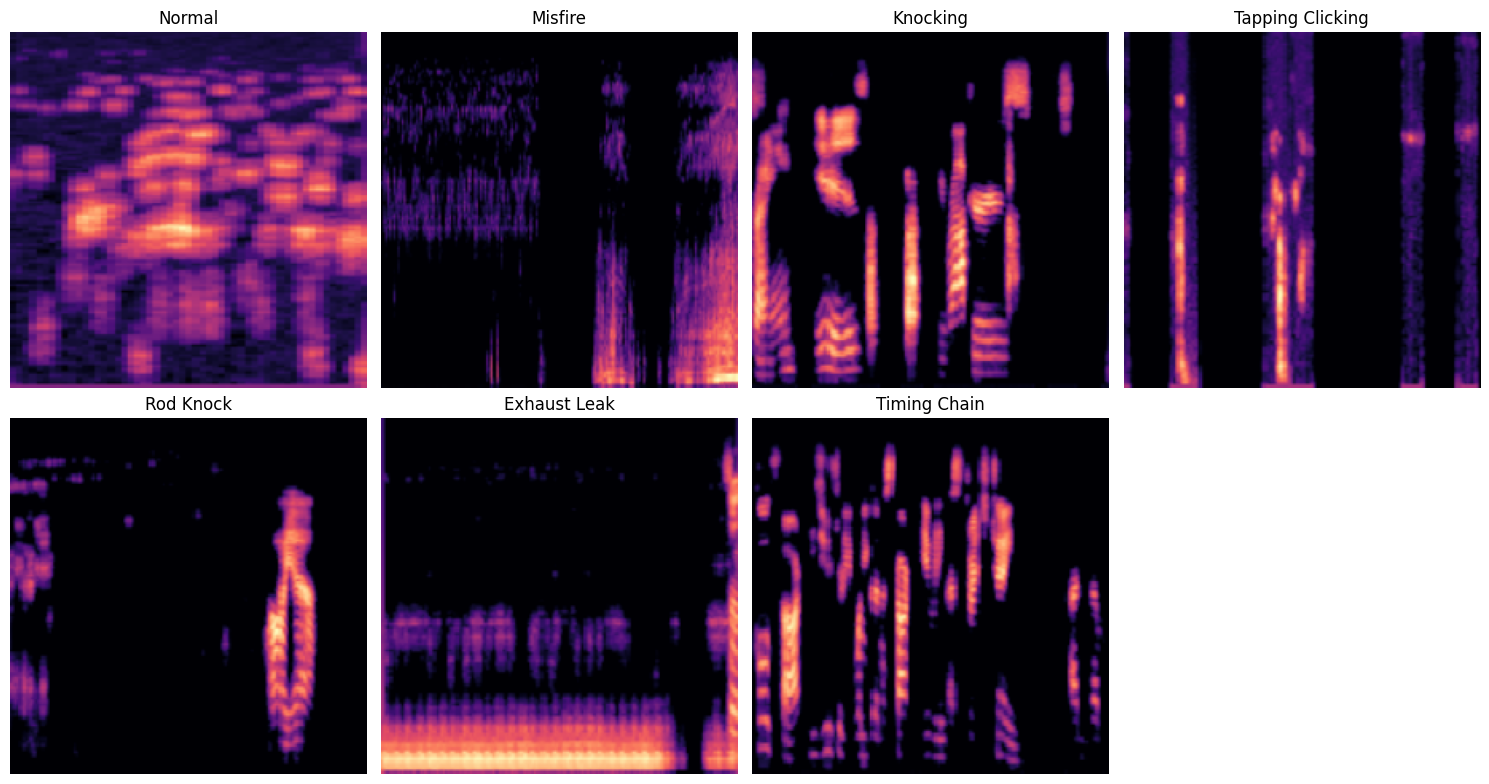

✅ Saved overview grid: sample_spectrograms.png
✅ Saved individual spectrograms: <Label>_example.png
✅ Saved captioned versions: <Label>_captioned.png


In [22]:
# ==========================
# STEP 5.5: Visualize & Save Sample Spectrograms
# ==========================
import matplotlib.image as mpimg

def save_cropped_spectrogram(img_path, label):
    """Save cropped + captioned spectrogram for thesis figures."""
    img = mpimg.imread(img_path)

    # Save clean cropped
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout(pad=0)
    clean_name = label.replace("_", " ")
    plt.savefig(f"{label}_example.png", dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

    # Save with caption
    plt.figure(figsize=(4, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Figure: {clean_name} Engine Fault Spectrogram", fontsize=10, pad=10)
    plt.tight_layout()
    plt.savefig(f"{label}_captioned.png", dpi=300, bbox_inches='tight')
    plt.close()

# Save combined grid
plt.figure(figsize=(15, 8))

for idx, label in enumerate(fault_links.keys()):
    label_dir = os.path.join(spec_dir, label)
    sample_file = random.choice(os.listdir(label_dir))
    sample_path = os.path.join(label_dir, sample_file)

    img = mpimg.imread(sample_path)

    # Add to overview grid
    plt.subplot(2, 4, idx+1)
    plt.imshow(img)
    plt.title(label.replace("_", " "))
    plt.axis("off")

    # Save cropped & captioned versions
    save_cropped_spectrogram(sample_path, label)

plt.tight_layout()
plt.savefig("sample_spectrograms.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

print("✅ Saved overview grid: sample_spectrograms.png")
print("✅ Saved individual spectrograms: <Label>_example.png")
print("✅ Saved captioned versions: <Label>_captioned.png")


📊 Normal: 50 spectrograms found
📊 Misfire: 50 spectrograms found
📊 Knocking: 50 spectrograms found
📊 Tapping_Clicking: 50 spectrograms found
📊 Rod_Knock: 50 spectrograms found
📊 Exhaust_Leak: 60 spectrograms found
📊 Timing_Chain: 60 spectrograms found

✅ Data prepared successfully:
Train: (259, 224, 224, 3) (259, 7)
Val:   (55, 224, 224, 3) (55, 7)
Test:  (56, 224, 224, 3) (56, 7)
💾 Label encoder saved as label_encoder.pkl
📊 Class distribution saved as class_distribution.csv


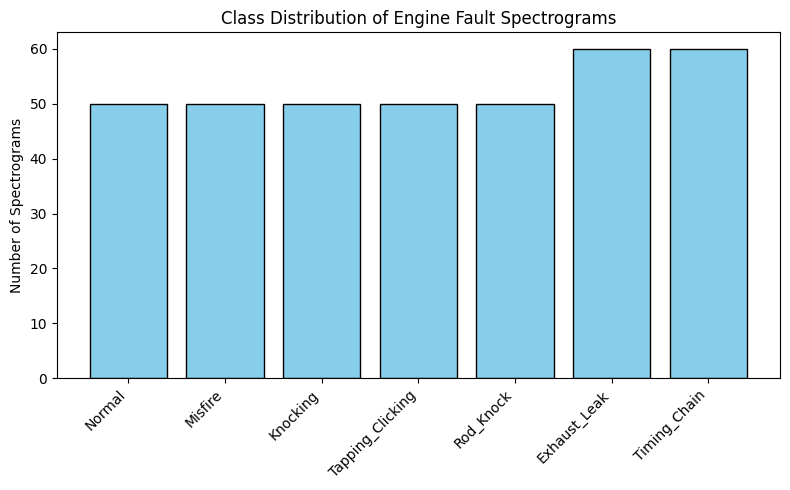

📊 Saved dataset distribution plot: class_distribution.png


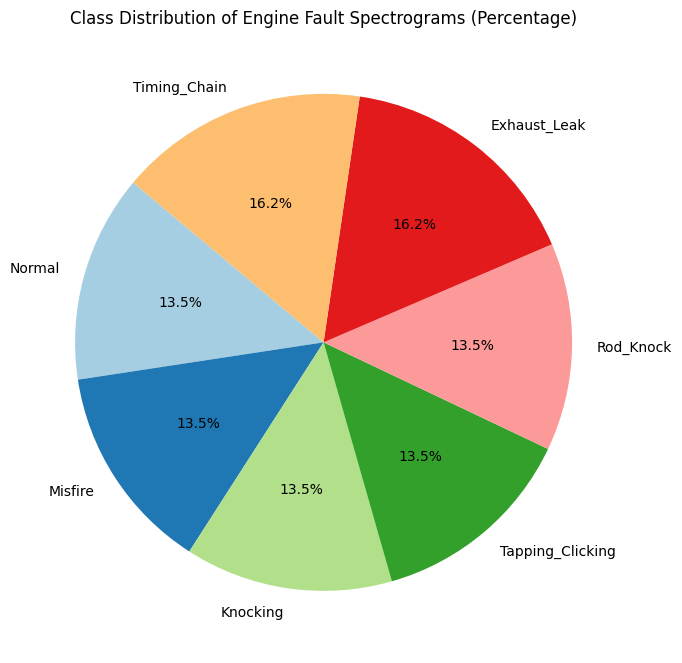

🥧 Saved dataset distribution pie chart: class_distribution_pie.png


In [23]:
# ==========================
# STEP 6: Prepare Data for Model Training + Save Class Distribution & Plot
# ==========================
import os, glob, cv2, joblib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Import train_test_split
import pandas as pd

# Define SEED for reproducibility
SEED = 42

# Re-import important globals
fault_links = {
    "Normal": ["https://youtu.be/U5M0gb0nXiw"],
    "Misfire": ["https://youtu.be/74ZTtGh5MN8"],
    "Knocking": ["https://youtu.be/kBWXxWD7g30", "https://www.youtube.com/watch?v=rG7s-gXrd10"],
    "Tapping_Clicking": ["https://youtu.be/O__pRR2HCS0"],
    "Rod_Knock": ["https://youtu.be/wmtBqNnnvrs"],
    "Exhaust_Leak": ["https://youtu.be/B9vCVByesGI"],
    "Timing_Chain": ["https://www.youtube.com/watch?v=lgTNkW0sj18", "https://youtu.be/2UcWsCP42t0"]
}

spec_dir = os.path.join("/content", "spectrograms")
IMG_SIZE = (224, 224)

X = []
y = []
class_counts = {}

# Load spectrogram images into arrays
for label in fault_links.keys():
    label_dir = os.path.join(spec_dir, label)
    files = glob.glob(os.path.join(label_dir, "*.png"))
    class_counts[label] = len(files)
    print(f"📊 {label}: {len(files)} spectrograms found")
    for f in files:
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(label)

X = np.array(X, dtype="float32") / 255.0  # normalize
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_cat, test_size=0.3, random_state=SEED, stratify=y_cat
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print("\n✅ Data prepared successfully:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

# Save label encoder
joblib.dump(le, "label_encoder.pkl")
print("💾 Label encoder saved as label_encoder.pkl")

# Save dataset distribution to CSV
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Num_Spectrograms"])
df_counts.to_csv("class_distribution.csv", index=False)
print("📊 Class distribution saved as class_distribution.csv")

# --------------------------
# Plot class distribution bar chart
# --------------------------
plt.figure(figsize=(8, 5))
plt.bar(df_counts["Class"], df_counts["Num_Spectrograms"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Spectrograms")
plt.title("Class Distribution of Engine Fault Spectrograms")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Saved dataset distribution plot: class_distribution.png")

# --------------------------
# Plot class distribution pie chart
# --------------------------
plt.figure(figsize=(7, 7))
plt.pie(
    df_counts["Num_Spectrograms"],
    labels=df_counts["Class"],
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Class Distribution of Engine Fault Spectrograms (Percentage)")
plt.tight_layout()
plt.savefig("class_distribution_pie.png", dpi=300, bbox_inches="tight")
plt.show()

print("🥧 Saved dataset distribution pie chart: class_distribution_pie.png")

📊 Tapping_Clicking: 50 spectrograms
📊 Timing_Chain: 60 spectrograms
📊 Misfire: 50 spectrograms
📊 Rod_Knock: 50 spectrograms
📊 Knocking: 50 spectrograms
📊 Exhaust_Leak: 60 spectrograms
📊 Normal: 50 spectrograms

✅ Data ready for training:
Train: (259, 224, 224, 3) (259, 7)
Val:   (55, 224, 224, 3) (55, 7)
Test:  (56, 224, 224, 3) (56, 7)
💾 Saved label encoder: label_encoder.pkl


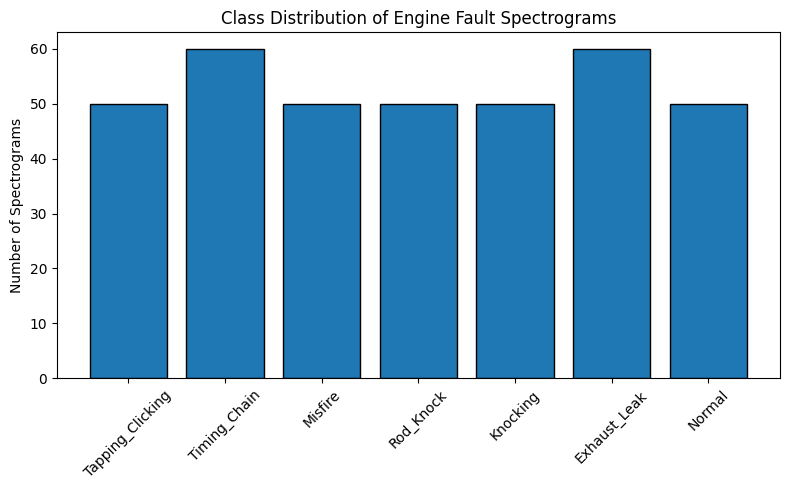

In [24]:
# ==========================
# STEP 6.5: Final Dataset Loader for CNN
# ==========================
import os, glob, cv2, joblib
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Reuse globals
spec_dir = os.path.join("/content", "spectrograms")
IMG_SIZE = (224, 224)

X, y = [], []
class_counts = {}

# Load spectrogram images
for label in os.listdir(spec_dir):
    label_dir = os.path.join(spec_dir, label)
    files = glob.glob(os.path.join(label_dir, "*.png"))
    class_counts[label] = len(files)
    print(f"📊 {label}: {len(files)} spectrograms")

    for f in files:
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(label)

X = np.array(X, dtype="float32") / 255.0
y = np.array(y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_cat, test_size=0.3, random_state=42, stratify=y_cat
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\n✅ Data ready for training:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

# Save label encoder
joblib.dump(le, "label_encoder.pkl")
print("💾 Saved label encoder: label_encoder.pkl")

# Save distribution
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Num_Spectrograms"])
df_counts.to_csv("class_distribution.csv", index=False)

plt.figure(figsize=(8,5))
plt.bar(df_counts["Class"], df_counts["Num_Spectrograms"], edgecolor="black")
plt.xticks(rotation=45)
plt.ylabel("Number of Spectrograms")
plt.title("Class Distribution of Engine Fault Spectrograms")
plt.tight_layout()
plt.savefig("class_distribution.png", dpi=300)
plt.show()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1718 - loss: 1.9610
Epoch 1: val_accuracy improved from -inf to 0.32727, saving model to cnn_best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.1754 - loss: 1.9567 - val_accuracy: 0.3273 - val_loss: 1.7853
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3638 - loss: 1.7229
Epoch 2: val_accuracy improved from 0.32727 to 0.41818, saving model to cnn_best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.3672 - loss: 1.7193 - val_accuracy: 0.4182 - val_loss: 1.5677
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5773 - loss: 1.4525
Epoch 3: val_accuracy improved from 0.41818 to 0.49091, saving model to cnn_best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5713 - loss: 1.4530 - val_accuracy: 0.4909 - val_loss: 1.4081
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5813 - loss: 1.2756
Epoch 4: val_accuracy improved from 0.49091 to 0.56364, saving model to cnn_best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5796 - loss: 1.2771 - val_accuracy: 0.5636 - val_loss: 1.2340
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7044 - loss: 1.0240
Epoch 5: val_accuracy improved from 0.56364 to 0.58182, saving model to cnn_best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7015 - loss: 1.0294 - val_accuracy: 0.5818 - val_loss: 1.1510
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7325 - loss: 0.8885
Epoch 6: val_accuracy improved from 0.58182 to 0.65455, saving model to cnn_best_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7291 - loss: 0.8919 - val_accuracy: 0.6545 - val_loss: 1.0551
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7640 - loss: 0.7952
Epoch 7: val_accuracy did not improve from 0.65455
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7640 - loss: 0.7941 - val_accuracy: 0.6182 - val_loss: 0.9942
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7896 - loss: 0.6074
Epoch 8: val_accuracy did not improve from 0.65455
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.7898 - loss: 0.6065 - val_accuracy: 0.6364 - val_loss: 0.9489
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8261 - loss: 0.5971
Epoch 9: val_accuracy did not improve from 0.65455
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.8269 - loss: 0.5943 - val_accuracy: 0.6545 - val_loss: 0.9232
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8656 - loss: 0.4196
Epoch 10: val_accuracy improved from 0.65455 to 0.74545, saving model 

9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8659 - loss: 0.4217 - val_accuracy: 0.7455 - val_loss: 0.8049
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8424 - loss: 0.4600
Epoch 11: val_accuracy did not improve from 0.74545
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8454 - loss: 0.4545 - val_accuracy: 0.6545 - val_loss: 0.8836
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9002 - loss: 0.3525
Epoch 12: val_accuracy did not improve from 0.74545
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9017 - loss: 0.3513 - val_accuracy: 0.7273 - val_loss: 0.8133
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9107 - loss: 0.2915
Epoch 13: val_accuracy did not improve from 0.74545
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9099 - loss: 0.2919 - val_accuracy: 0.6727 - val_loss: 0.9030
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9506 - loss: 0.2121
Epoch 14: val_accuracy did not improve from 0.74545
9/9 ━━━━━━━━

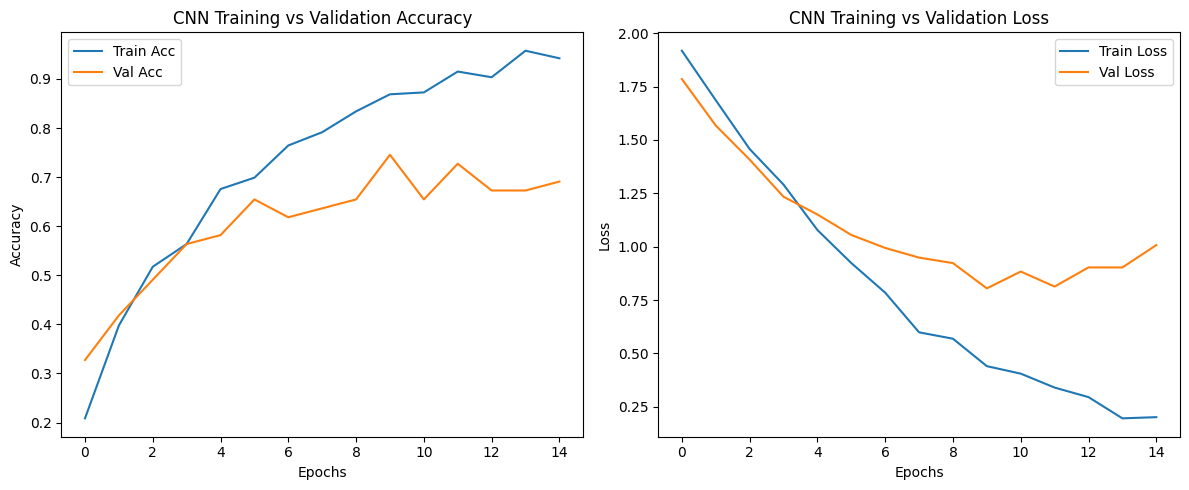

✅ CNN training complete!
💾 Best model saved as cnn_best_model.h5
📊 Training history plot saved as cnn_training_history.png


In [25]:
# ==========================
# STEP 7.1: CNN Baseline Model Training (Fixed)
# ==========================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ✅ Get number of classes safely (from y_cat created in Step 6)
try:
    num_classes = y_cat.shape[1]
except:
    raise NameError("❌ y_cat not found. Please run Step 6 first to prepare dataset splits.")

# Build CNN model (with clean Input API)
cnn_model = Sequential([
    Input(shape=(224, 224, 3)),     # Proper Input layer
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")   # ✅ Now uses num_classes instead of y_train
])

cnn_model.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
cnn_model.summary()

# Callbacks
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint("cnn_best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

# Train CNN
history_cnn = cnn_model.fit(
    X_train, y_train,               # requires Step 6 splits already in memory
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[es, mc],
    verbose=1
)

# ==========================
# Plot training history
# ==========================
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history["accuracy"], label="Train Acc")
plt.plot(history_cnn.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history["loss"], label="Train Loss")
plt.plot(history_cnn.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.savefig("cnn_training_history.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ CNN training complete!")
print("💾 Best model saved as cnn_best_model.h5")
print("📊 Training history plot saved as cnn_training_history.png")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 882ms/step - accuracy: 0.7604 - loss: 0.8165

✅ Test Accuracy: 0.7500
✅ Test Loss: 0.8951
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step

📊 Classification Report:
                  precision    recall  f1-score   support

    Exhaust_Leak       0.50      0.56      0.53         9
        Knocking       0.55      0.86      0.67         7
         Misfire       0.89      1.00      0.94         8
          Normal       1.00      1.00      1.00         8
       Rod_Knock       0.75      0.86      0.80         7
Tapping_Clicking       0.83      0.62      0.71         8
    Timing_Chain       1.00      0.44      0.62         9

        accuracy                           0.75        56
       macro avg       0.79      0.76      0.75        56
    weighted avg       0.79      0.75      0.75        56



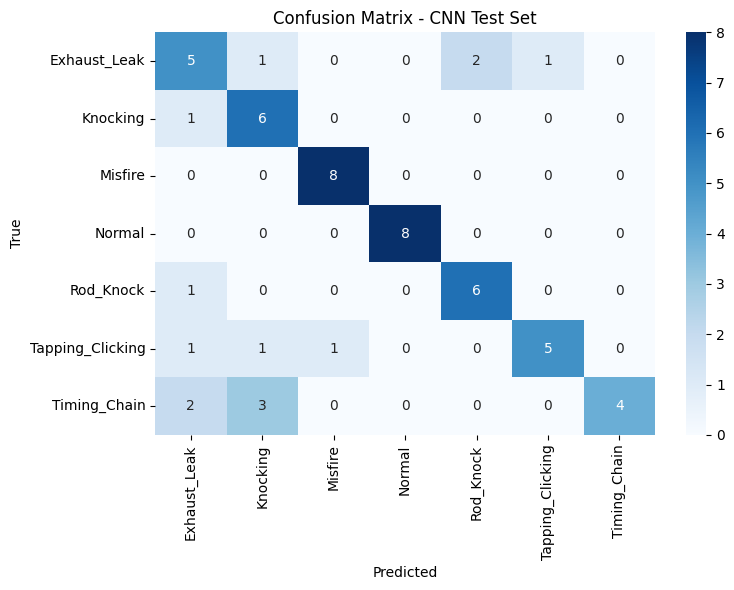

📊 Confusion matrix saved as cnn_confusion_matrix.png


In [26]:
# ==========================
# STEP 7.2: CNN Model Evaluation on Test Set
# ==========================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# Predict class labels
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Decode labels
le = joblib.load("label_encoder.pkl")
y_true_labels = le.inverse_transform(y_true)
y_pred_labels = le.inverse_transform(y_pred)

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN Test Set")
plt.tight_layout()
plt.savefig("cnn_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Confusion matrix saved as cnn_confusion_matrix.png")


RF feature shapes: (259, 4096) (55, 4096) (56, 4096)

✅ RF Test Accuracy: 0.7321

📊 RF Classification Report:
                  precision    recall  f1-score   support

    Exhaust_Leak       0.55      0.67      0.60         9
        Knocking       0.50      0.43      0.46         7
         Misfire       1.00      1.00      1.00         8
          Normal       0.89      1.00      0.94         8
       Rod_Knock       1.00      0.86      0.92         7
Tapping_Clicking       1.00      0.50      0.67         8
    Timing_Chain       0.50      0.67      0.57         9

        accuracy                           0.73        56
       macro avg       0.78      0.73      0.74        56
    weighted avg       0.77      0.73      0.73        56



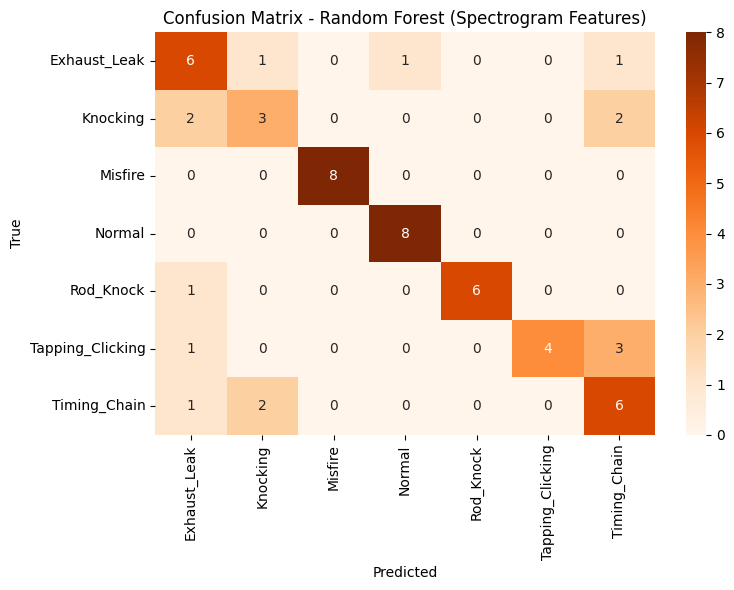

📊 RF confusion matrix saved as rf_confusion_matrix.png
💾 RF model saved as rf_spectrogram_baseline.joblib

🔬 Comparison — CNN acc: 0.7500  |  RF acc: 0.7321


In [27]:
# ==========================
# STEP 7.3: Random Forest Baseline (on compact spectrogram features)
# ==========================
import numpy as np, cv2, joblib, seaborn as sns, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Helper: turn images into compact RF features (64x64 grayscale) ---
def to_rf_features(X, size=(64, 64)):
    feats = []
    for img in X:
        g = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)  # img currently normalized 0..1
        g = cv2.resize(g, size, interpolation=cv2.INTER_AREA)
        feats.append(g.flatten().astype(np.float32) / 255.0)  # keep normalized
    return np.asarray(feats, dtype=np.float32)

# One-hot -> label indices for y
y_train_idx = np.argmax(y_train, axis=1)
y_val_idx   = np.argmax(y_val,   axis=1)
y_test_idx  = np.argmax(y_test,  axis=1)

# Build RF features (downscaled to 64x64 to avoid huge dimensionality)
X_train_rf = to_rf_features(X_train, size=(64, 64))
X_val_rf   = to_rf_features(X_val,   size=(64, 64))
X_test_rf  = to_rf_features(X_test,  size=(64, 64))

print("RF feature shapes:", X_train_rf.shape, X_val_rf.shape, X_test_rf.shape)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=SEED
)
rf.fit(X_train_rf, y_train_idx)

# Evaluate on test set
y_pred_rf_idx = rf.predict(X_test_rf)

# Accuracy
rf_acc = accuracy_score(y_test_idx, y_pred_rf_idx)
print(f"\n✅ RF Test Accuracy: {rf_acc:.4f}")

# Decode to class names
# (we saved LabelEncoder as 'le' earlier in Step 6)
le = joblib.load("label_encoder.pkl")
y_true_labels = le.inverse_transform(y_test_idx)
y_pred_labels = le.inverse_transform(y_pred_rf_idx)

# Classification report
print("\n📊 RF Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, labels=le.classes_))

# Confusion matrix
cm_rf = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest (Spectrogram Features)")
plt.tight_layout()
plt.savefig("rf_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
print("📊 RF confusion matrix saved as rf_confusion_matrix.png")

# Save RF model
joblib.dump(rf, "rf_spectrogram_baseline.joblib")
print("💾 RF model saved as rf_spectrogram_baseline.joblib")

# Optional: compare with CNN accuracy if available
try:
    print(f"\n🔬 Comparison — CNN acc: {test_acc:.4f}  |  RF acc: {rf_acc:.4f}")
except NameError:
    pass


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step

✅ Ensemble Test Accuracy (CNN+RF): 0.7679

📊 Ensemble Classification Report:
                  precision    recall  f1-score   support

    Exhaust_Leak       0.55      0.67      0.60         9
        Knocking       0.50      0.71      0.59         7
         Misfire       1.00      1.00      1.00         8
          Normal       0.89      1.00      0.94         8
       Rod_Knock       0.86      0.86      0.86         7
Tapping_Clicking       1.00      0.62      0.77         8
    Timing_Chain       0.83      0.56      0.67         9

        accuracy                           0.77        56
       macro avg       0.80      0.77      0.77        56
    weighted avg       0.80      0.77      0.77        56



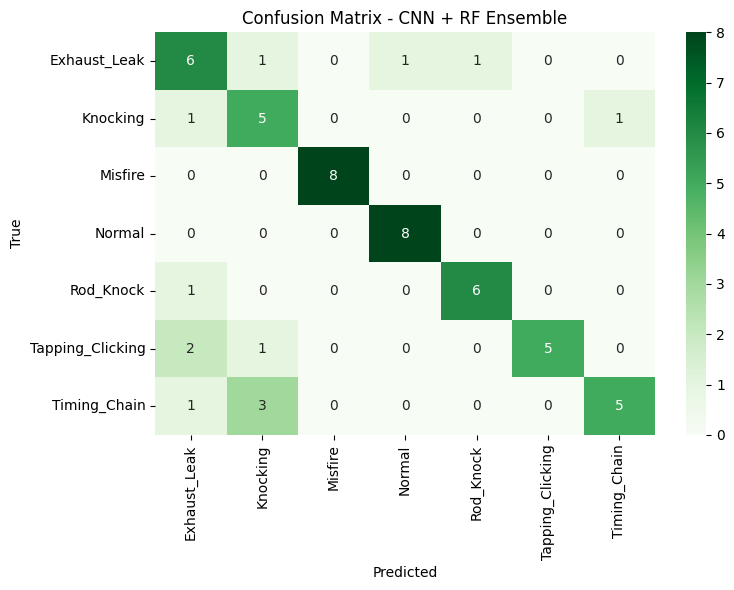

📊 Ensemble confusion matrix saved as ensemble_confusion_matrix.png
💾 Ensemble metadata saved (models + predictions)


In [28]:
# ==========================
# STEP 7.4: CNN + RF Ensemble (Soft Voting)
# ==========================
import numpy as np

# --- 1. CNN Predictions (probabilities) ---
y_pred_probs_cnn = cnn_model.predict(X_test)

# --- 2. RF Predictions (probabilities) ---
# RF was trained on 64x64 grayscale compact features
X_test_rf = to_rf_features(X_test, size=(64, 64))
y_pred_probs_rf = rf.predict_proba(X_test_rf)

# --- 3. Normalize RF output if class order differs ---
# Ensure both use the same order of classes
rf_class_order = rf.classes_           # numeric indices
cnn_class_order = np.arange(len(le.classes_))  # 0...N-1
assert np.array_equal(rf_class_order, cnn_class_order), "Class mismatch between CNN & RF!"

# --- 4. Ensemble Probabilities (average) ---
y_pred_probs_ensemble = (y_pred_probs_cnn + y_pred_probs_rf) / 2.0
y_pred_ensemble_idx = np.argmax(y_pred_probs_ensemble, axis=1)

# --- 5. Evaluation ---
y_true_idx = np.argmax(y_test, axis=1)
ensemble_acc = accuracy_score(y_true_idx, y_pred_ensemble_idx)

print(f"\n✅ Ensemble Test Accuracy (CNN+RF): {ensemble_acc:.4f}")

# Decode to labels
y_true_labels = le.inverse_transform(y_true_idx)
y_pred_labels = le.inverse_transform(y_pred_ensemble_idx)

# Classification Report
print("\n📊 Ensemble Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, labels=le.classes_))

# Confusion Matrix
cm_ens = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm_ens, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN + RF Ensemble")
plt.tight_layout()
plt.savefig("ensemble_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Ensemble confusion matrix saved as ensemble_confusion_matrix.png")

# --- 6. Save Ensemble Results ---
np.save("ensemble_probs.npy", y_pred_probs_ensemble)
joblib.dump({"cnn_model":"cnn_best_model.h5", "rf_model":"rf_spectrogram_baseline.joblib"},
            "ensemble_models.pkl")
print("💾 Ensemble metadata saved (models + predictions)")


In [30]:
# ==========================
# STEP 8.1 FIXED: CNN-LSTM (safe) — slice along width, use GAP per timestep
# ==========================
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    LSTM, Dense, Dropout, Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Safety / params
IMG_H, IMG_W, CH = 224, 224, 3
timesteps = 28                     # number of time slices
assert IMG_W % timesteps == 0, "IMG_W must be divisible by timesteps"
slice_w = IMG_W // timesteps       # width per time-step (e.g., 224//28 = 8)
num_classes = y_train.shape[1]

# Reshape: split width into timesteps slices
# Original X_train shape: (N, 224, 224, 3)
def reshape_for_lstm(X, timesteps=timesteps, slice_w=slice_w):
    N = X.shape[0]
    # reshape to (N, timesteps, IMG_H, slice_w, CH)
    Xr = X.reshape(N, IMG_H, timesteps, slice_w, CH)
    # move timesteps axis to position 1: (N, timesteps, IMG_H, slice_w, CH)
    Xr = np.transpose(Xr, (0, 2, 1, 3, 4))
    return Xr

X_train_lstm = reshape_for_lstm(X_train)
X_val_lstm   = reshape_for_lstm(X_val)
X_test_lstm  = reshape_for_lstm(X_test)

print("Shapes for LSTM input:")
print("X_train_lstm:", X_train_lstm.shape)
print("X_val_lstm:  ", X_val_lstm.shape)
print("X_test_lstm: ", X_test_lstm.shape)
# expected: (N, timesteps, 224, slice_w, 3)

# Build model with Input(...) to avoid warnings
inp = Input(shape=(timesteps, IMG_H, slice_w, CH), name="spec_sequence")

# TimeDistributed CNN feature extractor (use padding='same' and only a couple poolings)
x = TimeDistributed(Conv2D(32, (3,3), activation="relu", padding="same"))(inp)
x = TimeDistributed(MaxPooling2D((2,2), padding="same"))(x)

x = TimeDistributed(Conv2D(64, (3,3), activation="relu", padding="same"))(x)
x = TimeDistributed(MaxPooling2D((2,2), padding="same"))(x)

# reduce spatial dims per timestep to a feature vector (safe)
x = TimeDistributed(GlobalAveragePooling2D())(x)   # -> shape (batch, timesteps, features)

# Now LSTM over timesteps
x = LSTM(128, return_sequences=False)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation="softmax")(x)

cnn_lstm_model = Model(inputs=inp, outputs=out, name="cnn_lstm_safe")
cnn_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                       loss="categorical_crossentropy", metrics=["accuracy"])
cnn_lstm_model.summary()

# Callbacks
es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint("cnn_lstm_best_safe.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

# Train (smaller batch for memory)
history_cnn_lstm = cnn_lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=30,
    batch_size=8,                # reduce if you run out of mem
    callbacks=[es, mc],
    verbose=1
)

# Save model
cnn_lstm_model.save("cnn_lstm_safe.h5")
print("💾 Saved cnn_lstm_safe.h5")


Shapes for LSTM input:
X_train_lstm: (259, 28, 224, 8, 3)
X_val_lstm:   (55, 28, 224, 8, 3)
X_test_lstm:  (56, 28, 224, 8, 3)


Model: "cnn_lstm_safe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spec_sequence (InputLayer)      │ (None, 28, 224, 8, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 28, 224, 8, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 28, 112, 4, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 28, 112, 4, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 28, 56, 2, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 28, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,623 (529.78 KB)

 Trainable params: 135,623 (529.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1815 - loss: 1.9454
Epoch 1: val_accuracy improved from -inf to 0.12727, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.1812 - loss: 1.9453 - val_accuracy: 0.1273 - val_loss: 1.9389
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1750 - loss: 1.9367
Epoch 2: val_accuracy did not improve from 0.12727
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1748 - loss: 1.9366 - val_accuracy: 0.1273 - val_loss: 1.9288
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1591 - loss: 1.9307
Epoch 3: val_accuracy improved from 0.12727 to 0.16364, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.1588 - loss: 1.9306 - val_accuracy: 0.1636 - val_loss: 1.9143
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1808 - loss: 1.9085
Epoch 4: val_accuracy did not improve from 0.16364
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.1805 - loss: 1.9084 - val_accuracy: 0.1455 - val_loss: 1.8881
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1870 - loss: 1.8914
Epoch 5: val_accuracy improved from 0.16364 to 0.18182, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1870 - loss: 1.8914 - val_accuracy: 0.1818 - val_loss: 1.8616
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2983 - loss: 1.8362
Epoch 6: val_accuracy improved from 0.18182 to 0.29091, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2978 - loss: 1.8365 - val_accuracy: 0.2909 - val_loss: 1.8179
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3960 - loss: 1.7973
Epoch 7: val_accuracy improved from 0.29091 to 0.40000, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3958 - loss: 1.7980 - val_accuracy: 0.4000 - val_loss: 1.7734
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3890 - loss: 1.7687
Epoch 8: val_accuracy did not improve from 0.40000
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.3884 - loss: 1.7693 - val_accuracy: 0.3818 - val_loss: 1.7154
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4364 - loss: 1.7165
Epoch 9: val_accuracy improved from 0.40000 to 0.41818, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4347 - loss: 1.7175 - val_accuracy: 0.4182 - val_loss: 1.6613
Epoch 10/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3495 - loss: 1.6463
Epoch 10: val_accuracy improved from 0.41818 to 0.43636, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3493 - loss: 1.6473 - val_accuracy: 0.4364 - val_loss: 1.6068
Epoch 11/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3977 - loss: 1.6088
Epoch 11: val_accuracy did not improve from 0.43636
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.3974 - loss: 1.6099 - val_accuracy: 0.4000 - val_loss: 1.5585
Epoch 12/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4143 - loss: 1.6012
Epoch 12: val_accuracy did not improve from 0.43636
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4135 - loss: 1.6018 - val_accuracy: 0.4000 - val_loss: 1.5191
Epoch 13/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4459 - loss: 1.5413
Epoch 13: val_accuracy improved from 0.43636 to 0.45455, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4451 - loss: 1.5420 - val_accuracy: 0.4545 - val_loss: 1.4816
Epoch 14/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4856 - loss: 1.4465
Epoch 14: val_accuracy did not improve from 0.45455
33/33 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.4841 - loss: 1.4487 - val_accuracy: 0.4364 - val_loss: 1.4483
Epoch 15/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3967 - loss: 1.5197
Epoch 15: val_accuracy did not improve from 0.45455
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.3968 - loss: 1.5204 - val_accuracy: 0.4182 - val_loss: 1.4448
Epoch 16/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4609 - loss: 1.4143
Epoch 16: val_accuracy did not improve from 0.45455
33/33 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.4602 - loss: 1.4165 - val_accuracy: 0.4545 - val_loss: 1.4214
Epoch 17/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4604 - loss: 1.4105
Epoch 17: val_accuracy did not improve from 0.45

33/33 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.4366 - loss: 1.4283 - val_accuracy: 0.5091 - val_loss: 1.3968
Epoch 19/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4650 - loss: 1.4058
Epoch 19: val_accuracy did not improve from 0.50909
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4647 - loss: 1.4065 - val_accuracy: 0.4909 - val_loss: 1.3689
Epoch 20/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4657 - loss: 1.3607
Epoch 20: val_accuracy did not improve from 0.50909
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4642 - loss: 1.3632 - val_accuracy: 0.4727 - val_loss: 1.3538
Epoch 21/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4631 - loss: 1.3848
Epoch 21: val_accuracy did not improve from 0.50909
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.4619 - loss: 1.3867 - val_accuracy: 0.4545 - val_loss: 1.3690
Epoch 22/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4951 - loss: 1.3874
Epoch 22: val_accuracy did not improve from 0.50

33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.4934 - loss: 1.3394 - val_accuracy: 0.5455 - val_loss: 1.3201
Epoch 26/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5237 - loss: 1.2773
Epoch 26: val_accuracy did not improve from 0.54545
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5227 - loss: 1.2798 - val_accuracy: 0.5273 - val_loss: 1.3085
Epoch 27/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5251 - loss: 1.2481
Epoch 27: val_accuracy did not improve from 0.54545
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5239 - loss: 1.2506 - val_accuracy: 0.5455 - val_loss: 1.2893
Epoch 28/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5057 - loss: 1.2615
Epoch 28: val_accuracy improved from 0.54545 to 0.56364, saving model to cnn_lstm_best_safe.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5046 - loss: 1.2634 - val_accuracy: 0.5636 - val_loss: 1.2747
Epoch 29/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5072 - loss: 1.2865
Epoch 29: val_accuracy did not improve from 0.56364
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5062 - loss: 1.2883 - val_accuracy: 0.5636 - val_loss: 1.2616
Epoch 30/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5454 - loss: 1.2365
Epoch 30: val_accuracy did not improve from 0.56364
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5441 - loss: 1.2386 - val_accuracy: 0.5273 - val_loss: 1.2688
Restoring model weights from the end of the best epoch: 29.


💾 Saved cnn_lstm_safe.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4003 - loss: 1.4798

✅ CNN-LSTM Test Accuracy: 0.4286
✅ CNN-LSTM Test Loss: 1.4557
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step

📊 CNN-LSTM Classification Report:
                  precision    recall  f1-score   support

    Exhaust_Leak       0.33      0.11      0.17         9
        Knocking       0.20      0.29      0.24         7
         Misfire       0.67      0.50      0.57         8
          Normal       0.67      1.00      0.80         8
       Rod_Knock       0.22      0.29      0.25         7
Tapping_Clicking       0.00      0.00      0.00         8
    Timing_Chain       0.44      0.78      0.56         9

        accuracy                           0.43        56
       macro avg       0.36      0.42      0.37        56
    weighted avg       0.37      0.43      0.37        56



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


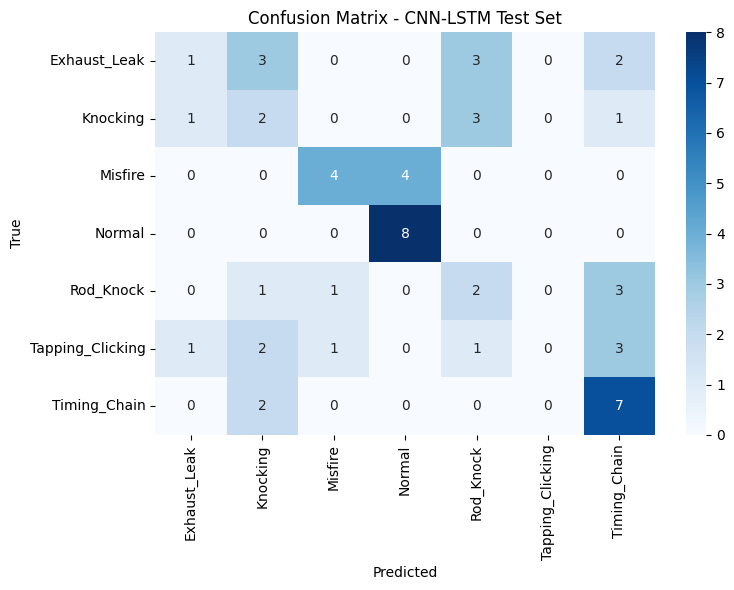

📊 CNN-LSTM confusion matrix saved as cnn_lstm_confusion_matrix.png


In [31]:
# ==========================
# STEP 8.2: CNN-LSTM Model Evaluation on Test Set
# ==========================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on test set
test_loss_lstm, test_acc_lstm = cnn_lstm_model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"\n✅ CNN-LSTM Test Accuracy: {test_acc_lstm:.4f}")
print(f"✅ CNN-LSTM Test Loss: {test_loss_lstm:.4f}")

# Predict class labels
y_pred_probs_lstm = cnn_lstm_model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)
y_true = np.argmax(y_test, axis=1)

# Decode labels
le = joblib.load("label_encoder.pkl")
y_true_labels = le.inverse_transform(y_true)
y_pred_labels_lstm = le.inverse_transform(y_pred_lstm)

# Classification report
print("\n📊 CNN-LSTM Classification Report:")
print(classification_report(y_true_labels, y_pred_labels_lstm))

# Confusion Matrix
cm_lstm = confusion_matrix(y_true_labels, y_pred_labels_lstm, labels=le.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN-LSTM Test Set")
plt.tight_layout()
plt.savefig("cnn_lstm_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 CNN-LSTM confusion matrix saved as cnn_lstm_confusion_matrix.png")


In [37]:
# ==========================
# STEP 9.1 (Fixed): Extract Handcrafted Features for Random Forest
# ==========================
import librosa
import numpy as np
import pandas as pd
import glob
import joblib
import os

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Time-domain features
    mean = np.mean(y)
    std = np.std(y)
    skewness = np.mean(((y - mean) / std) ** 3)
    kurtosis = np.mean(((y - mean) / std) ** 4) - 3

    # Frequency-domain features
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    return [mean, std, skewness, kurtosis, centroid, bandwidth]

# Use the correct dataset directory
dataset_dir = os.path.join("/content", "engine_sounds")
audio_files = glob.glob(os.path.join(dataset_dir, "*", "*.wav"))

features = []
labels = []

for file in audio_files:
    label = os.path.basename(os.path.dirname(file))  # folder name = class label
    feat = extract_features(file)
    features.append(feat)
    labels.append(label)

# Save to DataFrame
df_features = pd.DataFrame(features, columns=[
    "mean", "std", "skewness", "kurtosis", "centroid", "bandwidth"])
df_features["label"] = labels

df_features.to_csv("rf_features.csv", index=False)
print("✅ Features extracted and saved as rf_features.csv")
print("Total samples:", len(df_features))


/tmp/ipython-input-3554591002.py:17: RuntimeWarning: invalid value encountered in divide
  skewness = np.mean(((y - mean) / std) ** 3)
/tmp/ipython-input-3554591002.py:18: RuntimeWarning: invalid value encountered in divide
  kurtosis = np.mean(((y - mean) / std) ** 4) - 3


✅ Features extracted and saved as rf_features.csv
Total samples: 350


In [38]:
# ==========================
# STEP 9.2: Train Random Forest Classifier
# ==========================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load features
df = pd.read_csv("rf_features.csv")

X = df.drop("label", axis=1).values
y = df["label"].values

# Encode labels
from sklearn.preprocessing import LabelEncoder
le_rf = LabelEncoder()
y_encoded = le_rf.fit_transform(y)

joblib.dump(le_rf, "label_encoder_rf.pkl")

# Split data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train_rf, y_train_rf)

# Save model
joblib.dump(rf_model, "random_forest_model.pkl")
print("✅ Random Forest model trained and saved")


✅ Random Forest model trained and saved



📊 Random Forest Classification Report:
                  precision    recall  f1-score   support

    Exhaust_Leak       0.75      0.60      0.67        10
        Knocking       0.78      0.70      0.74        10
         Misfire       0.91      1.00      0.95        10
          Normal       1.00      1.00      1.00        10
       Rod_Knock       0.83      1.00      0.91        10
Tapping_Clicking       0.80      0.80      0.80        10
    Timing_Chain       0.70      0.70      0.70        10

        accuracy                           0.83        70
       macro avg       0.82      0.83      0.82        70
    weighted avg       0.82      0.83      0.82        70



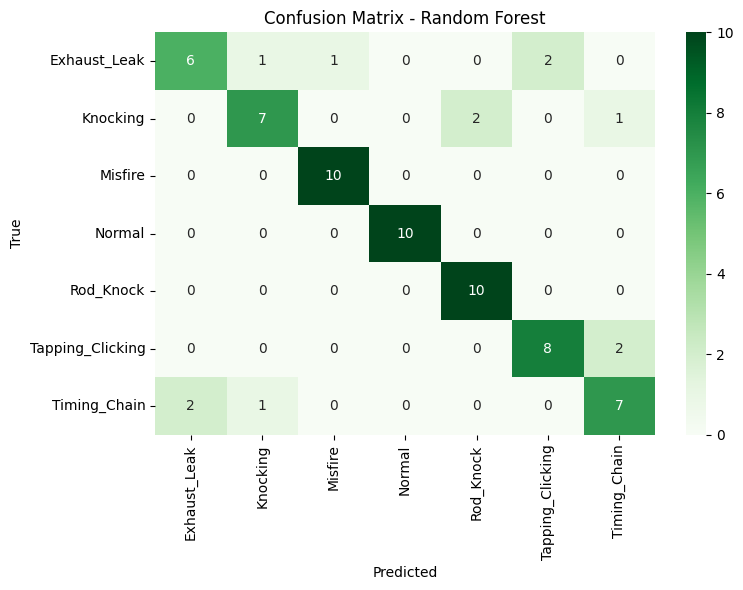

📊 Confusion matrix saved as rf_confusion_matrix.png


In [39]:
# ==========================
# STEP 9.3: Evaluate Random Forest
# ==========================
# Predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Decode labels
y_true_labels = le_rf.inverse_transform(y_test_rf)
y_pred_labels_rf = le_rf.inverse_transform(y_pred_rf)

# Classification Report
print("\n📊 Random Forest Classification Report:")
print(classification_report(y_true_labels, y_pred_labels_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_true_labels, y_pred_labels_rf, labels=le_rf.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=le_rf.classes_, yticklabels=le_rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.savefig("rf_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Confusion matrix saved as rf_confusion_matrix.png")



📊 Model Comparison:
           Model  Accuracy
0            CNN  0.750000
1  Random Forest  0.828571
💾 Model comparison saved as model_comparison.csv


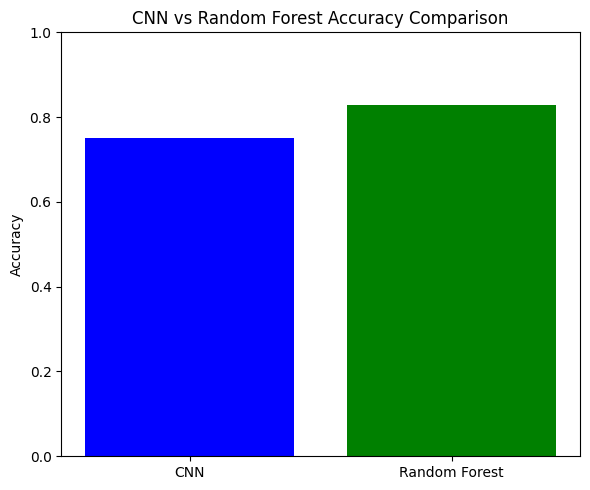

📊 Saved comparison plot: model_comparison.png


In [40]:
# ==========================
# STEP 9.4: Compare CNN vs Random Forest
# ==========================
import pandas as pd

# CNN metrics (already available from Step 7.2)
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

# RF metrics (from Step 9.3)
rf_acc = accuracy_score(y_true_labels, y_pred_labels_rf)

# Collect metrics
comparison = {
    "Model": ["CNN", "Random Forest"],
    "Accuracy": [cnn_test_acc, rf_acc]
}

df_comparison = pd.DataFrame(comparison)
print("\n📊 Model Comparison:")
print(df_comparison)

# Save to CSV
df_comparison.to_csv("model_comparison.csv", index=False)
print("💾 Model comparison saved as model_comparison.csv")

# Bar plot
plt.figure(figsize=(6,5))
plt.bar(df_comparison["Model"], df_comparison["Accuracy"], color=["blue","green"])
plt.ylabel("Accuracy")
plt.title("CNN vs Random Forest Accuracy Comparison")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print("📊 Saved comparison plot: model_comparison.png")


In [41]:
# ==========================
# STEP 10: Save and Deploy Best Model
# ==========================
import joblib
from tensorflow.keras.models import load_model

# --- Save CNN model ---
cnn_model.save("engine_fault_cnn.h5")
print("💾 CNN model saved as engine_fault_cnn.h5")

# --- Save Random Forest model ---
joblib.dump(rf_model, "engine_fault_rf.pkl")
print("💾 Random Forest model saved as engine_fault_rf.pkl")

# --- Save label encoders for reuse ---
joblib.dump(le, "cnn_label_encoder.pkl")
joblib.dump(le_rf, "rf_label_encoder.pkl")
print("💾 Label encoders saved for CNN and RF")

# ==========================
# Load models later for inference
# ==========================

# Load CNN
loaded_cnn = load_model("engine_fault_cnn.h5")
print("✅ CNN model loaded")

# Load Random Forest
loaded_rf = joblib.load("engine_fault_rf.pkl")
print("✅ Random Forest model loaded")

# Load encoders
loaded_le_cnn = joblib.load("cnn_label_encoder.pkl")
loaded_le_rf = joblib.load("rf_label_encoder.pkl")


💾 CNN model saved as engine_fault_cnn.h5
💾 Random Forest model saved as engine_fault_rf.pkl
💾 Label encoders saved for CNN and RF


✅ CNN model loaded
✅ Random Forest model loaded


In [45]:
# ==========================
# STEP 11: Inference Pipeline (robust)
# ==========================
import os, glob, random
import numpy as np
import librosa, cv2
import matplotlib.cm as cm
from tensorflow.keras.models import load_model
import joblib

# --- Load trained model + encoder ---
cnn_model = load_model("engine_fault_cnn.h5")
# compile to silence metrics warning when evaluating later (optional)
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

le = joblib.load("cnn_label_encoder.pkl")

IMG_SIZE = (224, 224)

def _spec_to_rgb(S_dB, size=(224,224)):
    """Convert mel dB spectrogram to RGB image using the same magma colormap used in training."""
    # normalize to 0..1
    S_min, S_max = S_dB.min(), S_dB.max()
    S_norm = (S_dB - S_min) / (S_max - S_min + 1e-8)
    rgb = cm.get_cmap("magma")(S_norm)[..., :3]   # RGBA -> RGB
    # resize to training size
    rgb_resized = cv2.resize((rgb*255).astype(np.uint8), size, interpolation=cv2.INTER_AREA)
    rgb_resized = cv2.cvtColor(rgb_resized, cv2.COLOR_BGR2RGB)
    return rgb_resized.astype("float32") / 255.0

def _clip_to_image(clip, sr):
    """Mel-spectrogram -> magma RGB image."""
    S = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return _spec_to_rgb(S_dB, IMG_SIZE)

def predict_engine_fault(audio_path, slice_seconds=2, top_k=4):
    """
    1) Validate audio path
    2) Slice into ~2s chunks (pad if too short)
    3) Make magma spectrogram images like training
    4) Run CNN, average slice probabilities
    5) Return Normal vs Faulty with ranked faults
    """
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")

    # Load audio
    y, sr = librosa.load(audio_path, sr=16000, mono=True)

    # Ensure we have at least one full slice
    slice_len = int(slice_seconds * sr)
    if len(y) < slice_len:
        pad_len = slice_len - len(y)
        y = np.pad(y, (0, pad_len), mode="constant")

    # Make equal-length slices
    slices = [y[i:i+slice_len] for i in range(0, len(y) - slice_len + 1, slice_len)]
    if not slices:
        # fallback: use whole audio
        slices = [y]

    # Build spectrogram images batch
    imgs = [_clip_to_image(clip, sr) for clip in slices]
    X_input = np.stack(imgs, axis=0)

    # Predict slice-wise and aggregate
    probs = cnn_model.predict(X_input, verbose=0)
    avg_probs = probs.mean(axis=0)

    classes = le.classes_
    class_probs = {cls: float(p) for cls, p in zip(classes, avg_probs)}

    top_idx = int(np.argmax(avg_probs))
    top_class = classes[top_idx]
    top_prob = float(avg_probs[top_idx])

    # If top is "Normal", return normal status; else return fault ranking
    if top_class == "Normal":
        return {
            "status": "Normal",
            "confidence": round(top_prob * 100, 2),
            "per_class": {k: round(v*100, 2) for k, v in class_probs.items()}
        }
    else:
        # sorted faults excluding "Normal"
        sorted_faults = sorted(
            [(cls, p) for cls, p in class_probs.items() if cls != "Normal"],
            key=lambda x: x[1], reverse=True
        )
        return {
            "status": "Faulty",
            "top_faults": [(cls, round(p*100, 2)) for cls, p in sorted_faults[:top_k]],
            "per_class": {k: round(v*100, 2) for k, v in class_probs.items()}
        }

# ==========================
# Example runs
# ==========================

# Option A: Use a file you already have (recommended):
# Pick any .wav from your dataset folders
dataset_dir = "/content/engine_sounds"
candidates = glob.glob(os.path.join(dataset_dir, "*", "*.wav"))
if candidates:
    test_path = random.choice(candidates)
    print("Testing on:", test_path)
    print(predict_engine_fault(test_path))
else:
    # Option B: Provide your own file path (upload or mount, then set this path)
    # test_path = "/content/test_engine.wav"
    # print(predict_engine_fault(test_path))
    print("No WAV files found under /content/engine_sounds/*/*.wav. Provide a valid audio path.")


/tmp/ipython-input-2477216895.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgb = cm.get_cmap("magma")(S_norm)[..., :3]   # RGBA -> RGB


Testing on: /content/engine_sounds/Tapping_Clicking/aug_6_O__pRR2HCS0_slice200_slice0.wav


{'status': 'Faulty', 'top_faults': [(np.str_('Timing_Chain'), 33.48), (np.str_('Exhaust_Leak'), 16.04), (np.str_('Tapping_Clicking'), 13.19), (np.str_('Rod_Knock'), 11.47)], 'per_class': {np.str_('Exhaust_Leak'): 16.04, np.str_('Knocking'): 10.58, np.str_('Misfire'): 8.85, np.str_('Normal'): 6.38, np.str_('Rod_Knock'): 11.47, np.str_('Tapping_Clicking'): 13.19, np.str_('Timing_Chain'): 33.48}}


In [46]:
# ==========================
# STEP 12: Hybrid Inference (CNN + Random Forest)
# ==========================
import numpy as np
import librosa, cv2, os
from tensorflow.keras.models import load_model
import joblib
import matplotlib.cm as cm

# --- Load trained models + encoders ---
cnn_model = load_model("engine_fault_cnn.h5")
rf_model = joblib.load("engine_fault_rf.pkl")

le_cnn = joblib.load("cnn_label_encoder.pkl")
le_rf = joblib.load("rf_label_encoder.pkl")

IMG_SIZE = (224, 224)

# --- CNN Prediction Helper ---
def predict_cnn(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    slice_len = 2 * sr
    slices = [y[i:i+slice_len] for i in range(0, len(y), slice_len) if len(y[i:i+slice_len]) == slice_len]

    predictions = []
    for clip in slices:
        S = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        S_img = cv2.resize(S_dB, IMG_SIZE)
        S_img = np.stack([S_img, S_img, S_img], axis=-1)
        S_img = S_img.astype("float32") / 255.0
        predictions.append(S_img)

    if len(predictions) == 0:
        return None

    X_input = np.array(predictions)
    probs = cnn_model.predict(X_input, verbose=0)
    avg_probs = np.mean(probs, axis=0)

    results = {cls: float(p) for cls, p in zip(le_cnn.classes_, avg_probs)}
    return results

# --- RF Prediction Helper ---
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mean = np.mean(y)
    std = np.std(y)
    skewness = np.mean(((y - mean) / std) ** 3)
    kurtosis = np.mean(((y - mean) / std) ** 4) - 3
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    return [mean, std, skewness, kurtosis, centroid, bandwidth]

def predict_rf(audio_path):
    feat = np.array(extract_features(audio_path)).reshape(1, -1)
    probs = rf_model.predict_proba(feat)[0]
    results = {cls: float(p) for cls, p in zip(le_rf.classes_, probs)}
    return results

# --- Hybrid Prediction ---
def predict_hybrid(audio_path, alpha=0.6):
    """
    alpha = weight for CNN (0.0–1.0), RF weight = (1 - alpha)
    """
    cnn_probs = predict_cnn(audio_path)
    rf_probs = predict_rf(audio_path)

    if cnn_probs is None or rf_probs is None:
        return {"error": "Prediction failed. Audio too short or unreadable."}

    # Align classes
    classes = le_cnn.classes_
    fused = {}
    for cls in classes:
        fused[cls] = alpha * cnn_probs.get(cls, 0) + (1 - alpha) * rf_probs.get(cls, 0)

    # Normalize
    total = sum(fused.values())
    fused = {k: v/total for k,v in fused.items()}

    # Sort by confidence
    sorted_faults = sorted(fused.items(), key=lambda x: x[1], reverse=True)

    # Decide status
    if sorted_faults[0][0] == "Normal":
        return {
            "status": "Normal",
            "confidence": round(sorted_faults[0][1]*100, 2),
            "cnn_top": max(cnn_probs, key=cnn_probs.get),
            "rf_top": max(rf_probs, key=rf_probs.get)
        }
    else:
        return {
            "status": "Faulty",
            "top_faults": [(cls, round(p*100,2)) for cls,p in sorted_faults if cls!="Normal"],
            "cnn_top": max(cnn_probs, key=cnn_probs.get),
            "rf_top": max(rf_probs, key=rf_probs.get)
        }

# ==========================
# Example Run
# ==========================
audio_file = "/content/engine_sounds/Knocking/aug_4_kBWXxWD7g30_slice25_clean.wav"  # replace with new test file
result = predict_hybrid(audio_file, alpha=0.7)

print("\n🔎 Hybrid Inference Result:")
print(result)



🔎 Hybrid Inference Result:
{'status': 'Faulty', 'top_faults': [(np.str_('Timing_Chain'), 60.56), (np.str_('Knocking'), 28.78), (np.str_('Exhaust_Leak'), 4.08), (np.str_('Tapping_Clicking'), 2.87), (np.str_('Rod_Knock'), 2.17), (np.str_('Misfire'), 1.09)], 'cnn_top': np.str_('Timing_Chain'), 'rf_top': 'Knocking'}


In [62]:
# ==========================
# STEP 13: Streamlit Frontend with ngrok (fixed for non-Jupyter)
# ==========================

# 1. Install dependencies
!pip install streamlit pyngrok -q

# 2. Add ngrok authtoken (only once needed, but safe to keep here)
!ngrok config add-authtoken 31gc2GwewTcxSbxvP2Ajc6BY2BY_3Meg6KhR2Sen4Ho6xEntr

# 3. Save app.py using normal Python write
app_code = """
import streamlit as st
import numpy as np
import librosa, cv2
import joblib
from tensorflow.keras.models import load_model

cnn_model = load_model("engine_fault_cnn.h5")
rf_model = joblib.load("engine_fault_rf.pkl")
le_cnn = joblib.load("cnn_label_encoder.pkl")
le_rf = joblib.load("rf_label_encoder.pkl")

IMG_SIZE = (224, 224)

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mean = np.mean(y)
    std = np.std(y)
    skewness = np.mean(((y - mean) / std) ** 3)
    kurtosis = np.mean(((y - mean) / std) ** 4) - 3
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    return [mean, std, skewness, kurtosis, centroid, bandwidth]

def predict_cnn(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    slice_len = 2 * sr
    slices = [y[i:i+slice_len] for i in range(0, len(y), slice_len) if len(y[i:i+slice_len]) == slice_len]
    predictions = []
    for clip in slices:
        S = librosa.feature.melspectrogram(y=clip, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        S_img = cv2.resize(S_dB, IMG_SIZE)
        S_img = np.stack([S_img, S_img, S_img], axis=-1)
        S_img = S_img.astype("float32") / 255.0
        predictions.append(S_img)
    if len(predictions) == 0:
        return None
    X_input = np.array(predictions)
    probs = cnn_model.predict(X_input, verbose=0)
    avg_probs = np.mean(probs, axis=0)
    return {cls: float(p) for cls, p in zip(le_cnn.classes_, avg_probs)}

def predict_rf(audio_path):
    feat = np.array(extract_features(audio_path)).reshape(1, -1)
    probs = rf_model.predict_proba(feat)[0]
    return {cls: float(p) for cls, p in zip(le_rf.classes_, probs)}

def predict_hybrid(audio_path, alpha=0.7):
    cnn_probs = predict_cnn(audio_path)
    rf_probs = predict_rf(audio_path)
    if cnn_probs is None:
        return {"error": "Audio too short"}
    classes = le_cnn.classes_
    fused = {cls: alpha*cnn_probs.get(cls,0) + (1-alpha)*rf_probs.get(cls,0) for cls in classes}
    total = sum(fused.values())
    fused = {k: v/total for k,v in fused.items()}
    sorted_faults = sorted(fused.items(), key=lambda x: x[1], reverse=True)
    if sorted_faults[0][0] == "Normal":
        return {"status": "Normal", "confidence": round(sorted_faults[0][1]*100,2)}
    else:
        return {"status": "Faulty", "faults": [(cls, round(p*100,2)) for cls,p in sorted_faults if cls!="Normal"]}

st.title("🔎 Engine Fault Detection System")
st.write("Upload an engine sound and classify it as **Normal** or **Faulty**.")

uploaded_file = st.file_uploader("Upload Engine Audio (.wav)", type=["wav"])
if uploaded_file is not None:
    with open("temp.wav", "wb") as f:
        f.write(uploaded_file.read())
    st.audio("temp.wav", format="audio/wav")
    result = predict_hybrid("temp.wav", alpha=0.7)
    if "error" in result:
        st.error(result["error"])
    elif result["status"] == "Normal":
        st.success(f"✅ Engine is NORMAL ({result['confidence']}%)")
    else:
        st.error("⚠️ Engine is FAULTY")
        for fault, prob in result["faults"]:
            st.write(f"- {fault}: {prob}%")
"""

with open("app.py", "w") as f:
    f.write(app_code)

# 4. Run streamlit + expose with ngrok
import subprocess
from pyngrok import ngrok

!streamlit run app.py &>/dev/null &

public_url = ngrok.connect(8501)
print("🌍 Public URL:", public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌍 Public URL: NgrokTunnel: "https://68b553405f90.ngrok-free.app" -> "http://localhost:8501"


In [61]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Run Streamlit
!streamlit run app.py &

# Create ngrok tunnel
public_url = ngrok.connect(8501)
print("🌍 Public URL:", public_url)





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.30.131.139:8501

  Stopping...
🌍 Public URL: NgrokTunnel: "https://f9f0c370c2ed.ngrok-free.app" -> "http://localhost:8501"
